In [1]:
from utils import sanitize
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions, AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rxnmapper import RXNMapper
rxnmapper = RXNMapper()
import random

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expec

In [4]:
def entry2smarts(rxn_entry):
    '''
    Convert our standard rxn json
    entry into a reaction smarts
    '''
    reactants = sanitize(list(rxn_entry[0].values()))
    products = sanitize(list(rxn_entry[1].values()))
    sma = ".".join(reactants) + ">>" + ".".join(products)
    return sma

def atom_map(rxn_sma):
    return rxnmapper.get_attention_guided_atom_maps([rxn_sma])[0]['mapped_rxn']

def shuffle_mol(mol):
    '''
    '''
    idxs = [i for i in range(len(list(mol.GetAtoms())))]
    random.shuffle(idxs)
    shuffle_mol = Chem.RWMol() # New mol object to be edited
    old2new = {}
    # Add atoms, set formal charge
    for i, elt in enumerate(idxs):
        atom = mol.GetAtomWithIdx(elt)
        fc = atom.GetFormalCharge()
        amap_num = atom.GetAtomMapNum()
        anum = atom.GetAtomicNum()
        old2new[elt] = i
        shuffle_mol.AddAtom(Chem.Atom(anum))
        shuffle_mol.GetAtomWithIdx(i).SetFormalCharge(fc)
        shuffle_mol.GetAtomWithIdx(i).SetAtomMapNum(amap_num)

    # Add bonds
    for a1 in idxs:
        for a2 in idxs:
            if a1 < a2:
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is not None:
                    b_type = bond.GetBondType() # Single, double, ...
                    shuffle_mol.AddBond(old2new[a1], old2new[a2], b_type)

    shuffle_mol = Chem.Mol(shuffle_mol)
    Chem.SanitizeMol(shuffle_mol) # Trust in Greg Landrum
    return shuffle_mol

def get_sub_mol(mol, ratoms):
    '''
    Given mol object and tuple
    of atom indices returns mol 
    of the part of the mol with
    atoms at those indices incl bonds if applicable
    '''
    sub_mol = Chem.RWMol() # New mol object to be edited
    old2new = {}
    # Add atoms, set formal charge
    for i, elt in enumerate(ratoms):
        atom = mol.GetAtomWithIdx(elt)
        fc = atom.GetFormalCharge()
        amap_num = atom.GetAtomMapNum()
        anum = atom.GetAtomicNum()
        old2new[elt] = i
        sub_mol.AddAtom(Chem.Atom(anum))
        sub_mol.GetAtomWithIdx(i).SetFormalCharge(fc)
        sub_mol.GetAtomWithIdx(i).SetAtomMapNum(amap_num)

    # Add bonds
    for a1 in ratoms:
        for a2 in ratoms:
            if a1 < a2:
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is not None:
                    b_type = bond.GetBondType() # Single, double, ...
                    sub_mol.AddBond(old2new[a1], old2new[a2], b_type)

    sub_mol = Chem.Mol(sub_mol)
    Chem.SanitizeMol(sub_mol) # Trust in Greg Landrum
    return sub_mol

def align_substrates(rcs, remaining):
    '''
    Aligns substrates of two reactions based on 
    their reactions centers being equivalent.
    Args
        - rcs: List of lists of mol obj rxn ctrs
        - remaingin: List of lists of remaining rc idxs
    Returns
        - aligned idxs in order rxn1, rxn2
    '''

    for i in remaining[0]:
        for j in remaining[1]:
            rc1 = rcs[0][i]
            rc2 = rcs[1][j]
            res = rdFMCS.FindMCS([rc1, rc2], bondCompare=rdFMCS.BondCompare.CompareOrder,
               atomCompare=rdFMCS.AtomCompare.CompareElements, matchValences=True
               )
            if (res.numAtoms == max(rc1.GetNumAtoms(), rc2.GetNumAtoms())) &\
                (res.numBonds == max(rc1.GetNumBonds(), rc2.GetNumBonds())):
                idx_pair = (i, j)
                return idx_pair
            
    return None

def sort_x_by_y(x, y, reverse=False):
    yx = list(zip(y, x))
    sorted_yx = sorted(yx, reverse=reverse)
    y, x = list(zip(*sorted_yx))
    return x, y

'''
Inputs: mol obj and mol obj of substructure like rc
which matches substructure in first mol obj but
with different permutations of atom idxs, AND
ratoms: idxs of reaction center of mol obj from which mol
obj 2 was constrcuted. ASSUME you've already aligned subs 
based on rcs

- permute rc1's atom mapping list w/ prop tup (atomicnum, bonds (type, partners), formal charge) until
prop tup equal to mol2's prop tup eltwise. Then set atom num in that order

Steps:
    - Get rc alignment idx pair
    - Get rc pair and mol pair
    - Get mol2 ratoms
    - Get property tuple for atoms in mol2 indexed at
    mol2 ratoms
    - Get property tuple for atoms in rc1
    - Hash pts
    - Sort mol2 pt
    - Sort rc1 atommapnums by rc1 pt
    - Ensure that property tuples are equal
    - Set mol2 atommapnums in order of sorted rc1 atommapnums

'''
def get_property_hashes(mol, aidxs):
    prop_hashes = []
    for idx in aidxs:
        atom = mol.GetAtomWithIdx(idx)
        this_prop = [atom.GetAtomicNum(), atom.GetFormalCharge()]
        bonds = []
        for bond in atom.GetBonds():
            if (bond.GetBeginAtomIdx() == idx) & (bond.GetEndAtomIdx() in aidxs):
                bonds.append((bond.GetBondType(), bond.GetEndAtom().GetAtomicNum()))
            
            if (bond.GetBeginAtomIdx() != idx) & (bond.GetBeginAtomIdx() in aidxs):
                bonds.append((bond.GetBondType(), bond.GetBeginAtom().GetAtomicNum()))
        
        this_prop += bonds
        this_prop = tuple(this_prop)
        prop_hashes.append(hash(this_prop))

    prop_hashes = tuple(prop_hashes)

    return prop_hashes

def align_atom_map_nums(rxns, rcs, rc_idxs, rc_atoms):
    for elt in rc_idxs:
        rc1 = rcs[0][elt[0]]
        mol2 = rxns[1].GetReactantTemplate(elt[1])
        ratoms2 = rc_atoms[1][elt[1]]
        rc1_atom_idxs = [i for i in range(len(rc1.GetAtoms()))]
        
        rc_amap_nums = []
        for elt in rc1_atom_idxs:
            rc_amap_nums.append(rc1.GetAtomWithIdx(elt).GetAtomMapNum())

        mol2_prop_hashes = get_property_hashes(mol2, ratoms2)
        rc1_prop_hashes = get_property_hashes(rc1, rc1_atom_idxs)

        ratoms2, mol2_prop_hashes = tuple(sort_x_by_y(ratoms2, mol2_prop_hashes))
        rc_amap_nums, rc1_prop_hashes = tuple(sort_x_by_y(rc_amap_nums, rc1_prop_hashes))

        print(mol2_prop_hashes == rc1_prop_hashes)

        for i, elt in enumerate(ratoms2):
            mol2.GetAtomWithIdx(elt).SetAtomMapNum(rc_amap_nums[i])


    return rxns

def get_prc_mcs(rxns, rcs, rc_idxs, rc_atoms):
    for i, rxn in enumerate(rxns):
        for j, sub in enumerate(rxn.GetReactants()):
            for atom in sub.GetAtoms():
                atom_idx = atom.GetIdx()
                if atom_idx in rc_atoms[i][j]:
                    atom.SetIsotope(atom.GetAtomMapNum() * atom.GetAtomicNum() * 99) # Rxn ctr atom
                else:
                    atom.SetIsotope(atom.GetAtomicNum()) # Non rxn ctr atom

    for rc in rcs[0]:
        for atom in rc.GetAtoms():
            atom.SetIsotope(atom.GetAtomMapNum() * atom.GetAtomicNum() * 99)

    prc_mcs = []
    for elt in rc_idxs:
        subs = [rxns[0].GetReactantTemplate(elt[0]),  rxns[1].GetReactantTemplate(elt[1])]
        rc = rcs[0][elt[0]]

        ss = Chem.MolToSmarts(rc)
        res = rdFMCS.FindMCS(subs, seedSmarts=ss,
                                atomCompare=rdFMCS.AtomCompare.CompareIsotopes,
                                bondCompare=rdFMCS.BondCompare.CompareOrder
                            ) # Left out matchValences for now...
        prc_mcs.append(res.numAtoms / min(subs[0].GetNumAtoms(), subs[1].GetNumAtoms())) # Normalize by min rn. Max may make sense too

    return prc_mcs

In [6]:
# Develop rxns -> PRC MCS Index

pred_rxn_sma = 'O=C(O)CCC(CC(=O)O)C(=O)O.\
                NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1\
                >>O=C(O)C=C(CCC(=O)O)C(=O)O.\
                NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1'

known_rxn_entry = [{'(2R)-2-methylbutanedioic acid:0': 'CC(CC(=O)O)C(=O)O',
                    'NAD+:0': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'},
                    {'NADH:0': 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
                    'citraconic acid:0': 'CC(=CC(=O)O)C(=O)O'}]

known_rxn_sma = entry2smarts(known_rxn_entry)

rxn_sma1 = pred_rxn_sma
rxn_sma2 = known_rxn_sma

'''
'''
am_rxn_smarts = [atom_map(rxn_sma1), atom_map(rxn_sma2)] # Atom map

# Construct reaction objects
rxns = []
for elt in am_rxn_smarts:
    temp = AllChem.ReactionFromSmarts(elt, useSmiles=True)
    temp.Initialize()
    rxns.append(temp)

rc_atoms = [elt.GetReactingAtoms() for elt in rxns] # Get reaction center atom idxs

# Construct rxn ctr mol objs
rcs = []
for i, t_rxn in enumerate(rxns):
    temp = []
    for j, t_mol in enumerate(t_rxn.GetReactants()):
        temp.append(get_sub_mol(t_mol, rc_atoms[i][j]))
    rcs.append(temp)

# Align substrates of the 2 reactions
rc_idxs = [] # Each element: (idx for rxn 1, idx for rxn 2)
remaining = [[i for i in range(len(elt))] for elt in rcs]
while (len(remaining[0]) > 0) & (len(remaining[1]) > 0):
    idx_pair = align_substrates(rcs, remaining)

    if idx_pair is None:
        break
    else:
        rc_idxs.append(idx_pair)
        remaining[0].remove(idx_pair[0])
        remaining[1].remove(idx_pair[1])

# Re-label atom map nums in substrate pairs
# so that reaction centers of aligned subs
# take atommapnum from rxn1 arbitrarily
# (Necessary for PRC MCS)
rxns = align_atom_map_nums(rxns, rcs, rc_idxs, rc_atoms)

prc_mcs = get_prc_mcs(rxns, rcs, rc_idxs, rc_atoms) # Compute MCS seeded by reaction center
prc_mcs

True
True


[1.0, 0.8888888888888888]

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


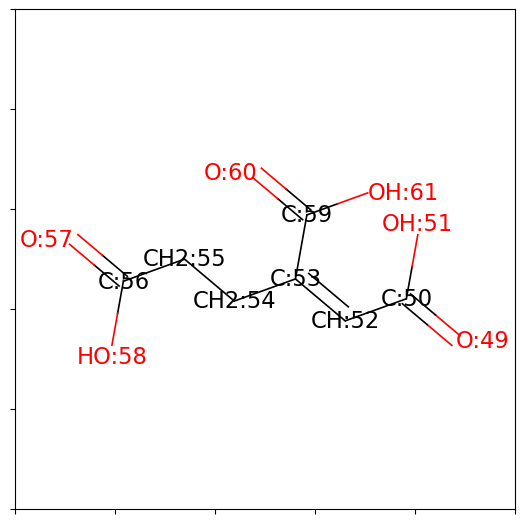

In [40]:
prod = pred_rxn.GetProductTemplate(1)
img = Draw.MolToMPL(prod, size=(200,200))
img.show()